In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import imblearn
from imblearn.over_sampling import RandomOverSampler

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline
RSEED = 42



/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df_raw = pd.read_csv('data/data/Kickstarter000.csv')
for i in range(1, 56):
    filename = 'data/data/Kickstarter0' + str(i).zfill(2) + '.csv'
    tt = pd.read_csv(filename)
    df_raw = pd.concat([df_raw, tt], axis=0)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 964
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obje

In [3]:
df_raw.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

In [4]:
#df_raw

In [56]:
df = df_raw[['blurb', 'category','country', 'created_at', 
       'currency','deadline', 'goal', 'id',
       'launched_at', 'location','name', 'slug',
       'source_url', 'state', 
       'urls', 'usd_pledged']] # , 'usd_type'

In [57]:
df.dropna(axis=0, inplace=True)

/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [58]:
# Month of project deadline
df['month'] = pd.to_datetime(df['launched_at'], unit='s').dt.month
#df

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_85981/3943520250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['launched_at'], unit='s').dt.month


In [59]:
# Duration the the project was online
df.eval('duration = (deadline - launched_at)/3600/24', inplace=True)
# Time between project creation and launchin
df.eval('duration_start_launch = (launched_at - created_at)/3600/24', inplace=True)
df.drop(['deadline', 'created_at', 'launched_at'], axis=1, inplace=True)
#df.head()

/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [60]:
df.eval('goal_per_duration = goal / duration', inplace=True)

In [61]:
# Extract category nae
import json
df['category_name'] = df['category'].apply(lambda x : json.loads(x)['name'])
df.drop('category', axis=1, inplace=True)
#df.head()

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_85981/4201644507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_name'] = df['category'].apply(lambda x : json.loads(x)['name'])
/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [62]:
# Get name length
df['name_length'] = df['name'].apply(lambda x : len(x.split(' ')))
df.drop('name', axis=1, inplace=True)

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_85981/2960411482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name_length'] = df['name'].apply(lambda x : len(x.split(' ')))


In [63]:
df['blurb_length'] = df['blurb'].apply(lambda x : len(x.split(' ')))
df.drop('blurb', axis=1, inplace=True)

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_85981/3027176886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blurb_length'] = df['blurb'].apply(lambda x : len(x.split(' ')))


In [64]:
# Extract city name
df['city'] = df['location'].map(lambda x : (x.split('"'))[5])
df.drop('location', axis=1, inplace=True)

/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/ipykernel_85981/1543756393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city'] = df['location'].map(lambda x : (x.split('"'))[5])


In [66]:
df['successful'] = (df['state'] == 'successful').astype(int)
df = df[~df['state'].isin(['canceled', 'live', 'suspended'])]
df.drop('state', axis=1, inplace=True)

KeyError: 'state'

## Data cleaning
Removing duplicate rows, removing outliers, ...

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192409 entries, 0 to 964
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                192409 non-null  object 
 1   currency               192409 non-null  object 
 2   goal                   192409 non-null  float64
 3   id                     192409 non-null  int64  
 4   slug                   192409 non-null  object 
 5   source_url             192409 non-null  object 
 6   urls                   192409 non-null  object 
 7   usd_pledged            192409 non-null  float64
 8   usd_type               192409 non-null  object 
 9   month                  192409 non-null  int64  
 10  duration               192409 non-null  float64
 11  duration_start_launch  192409 non-null  float64
 12  goal_per_duration      192409 non-null  float64
 13  category_name          192409 non-null  object 
 14  name_length            192409 non-null 

In [68]:
df_drop_dup = df.drop_duplicates(subset='id', keep='last')
#df_drop_dup.info()

In [69]:
df_drop_dup = df_drop_dup[df_drop_dup['name_length'] <= 20]

In [70]:
#df_drop_dup['blurb_length'].hist()
df_drop_dup = df_drop_dup[df_drop_dup['blurb_length'] <= 40]

In [71]:
#df_drop_dup['goal'].hist()
df_drop_dup = df_drop_dup[df_drop_dup['goal'] <= 10000000]

In [73]:
df_drop_dup = df_drop_dup[df_drop_dup['duration_start_launch'] <= 1000]

In [74]:
df_dummies = pd.get_dummies(df_drop_dup, columns=['country', 'currency', 'category_name', 'month', 'usd_type'], drop_first=True)

In [75]:
features_dummies = list(df_dummies.columns)
features = list(df.columns)
for i in ['id', 'slug', 'source_url', 'urls',
        'usd_pledged', 'city']:
    features_dummies.remove(i)
    features.remove(i)

## Profile report

In [76]:
#from pandas_profiling import ProfileReport
##profile = ProfileReport(df[features], title="Pandas Profiling Report", explorative=True)
#profile

## Baseline model

## Simple Decision Tree Model

In [77]:
%run Helper_methods.ipynb    

In [78]:
X = df[['name_length']]
y = np.array(df['successful'])
train, test, train_label, test_label = train_test_split(X, y, stratify=y, 
                    random_state=RSEED, test_size=0.3)

In [79]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(train, train_label)
y_pred = clf.predict(test)

accuracy_score 0.6178473052336158
f1-score 0.7432820882842412
[[ 3730 18815]
 [ 3244 31934]]
Confusion matrix, without normalization
[[ 3730 18815]
 [ 3244 31934]]


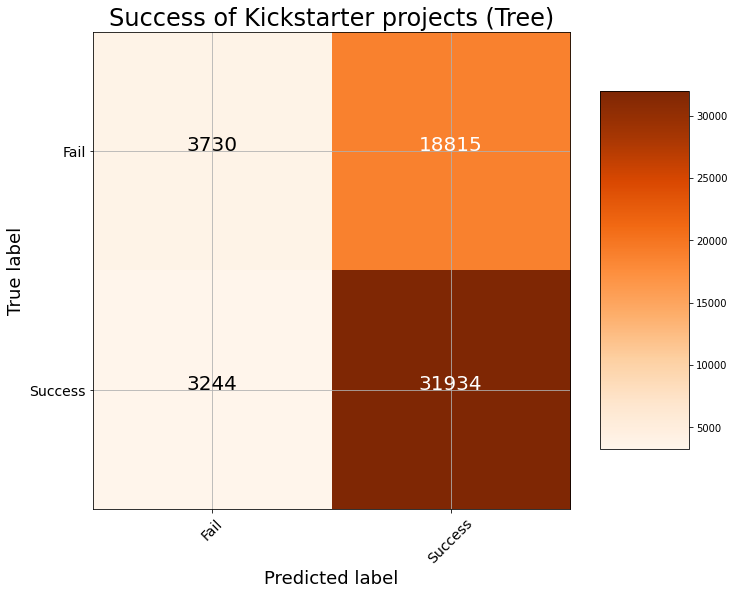

In [80]:
print('accuracy_score', accuracy_score(test_label, y_pred))
print('f1-score', f1_score(test_label, y_pred))
cm = confusion_matrix(test_label, y_pred)
print(cm)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Tree)'
)

## Correct imbalance

In [81]:
X = df_dummies[features_dummies].drop('successful',axis=1)
y = np.array(df_dummies['successful'])

In [82]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=RSEED)
X_over, y_over = oversample.fit_resample(X, y)
train, test, train_label, test_label = train_test_split(X_over, y_over, stratify=y_over, 
                    random_state=RSEED, test_size=0.3)

In [83]:
yy = pd.Series(y_over)
df_bal = pd.concat([X_over, yy],axis=1)
df_bal.head()

,goal,duration,duration_start_launch,goal_per_duration,name_length,blurb_length,country_AU,country_BE,country_CA,country_CH,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,usd_type_international,0
0,200.0,45.000000,4.066620,4.444444,4,26,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1,1000.0,30.000000,2.459491,33.333333,4,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20000.0,10.958785,211.789410,1825.019882,7,22,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,14500.0,30.000000,45.005729,483.333333,5,17,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,10000.0,31.000000,22.271551,322.580645,1,9,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


<AxesSubplot:>

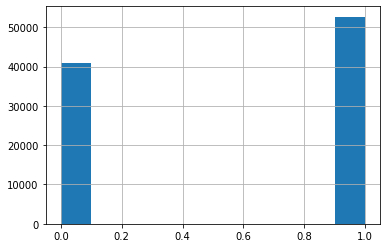

In [84]:
df_bal[df_bal['name_length'] > 5][0].hist()

<function matplotlib.pyplot.show(close=None, block=None)>

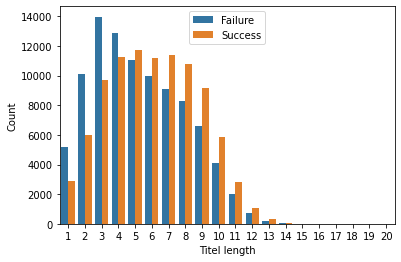

In [85]:
ax = sns.countplot(data=df_bal, x="name_length", hue=0)
ax.set(xlabel= 'Titel length', ylabel='Count')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Failure','Success'])#, bbox_to_anchor=(1,1))
plt.show

## Simple Tree model

accuracy_score 0.7799653293709757
f1-score 0.7629808883214878
Confusion matrix, without normalization
[[24072  4194]
 [ 8245 20021]]


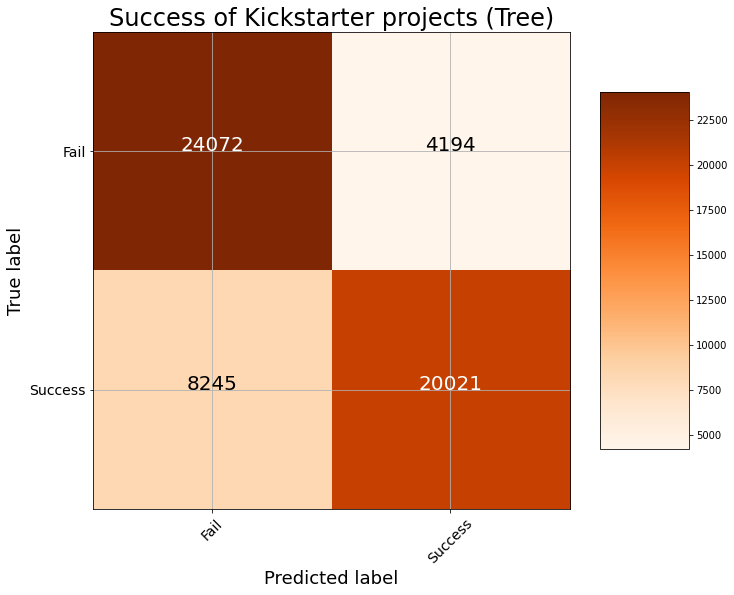

In [86]:
clf_tree = DecisionTreeClassifier()
y_pred_tree = clf_train_predict(clf_tree, train, train_label, test)
cm = simple_metrics(test_label, y_pred_tree)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Tree)'
)

Sclaing of Features

In [87]:
scaler = StandardScaler()
col_scale = ['goal', 'duration', 'duration_start_launch', 'name_length', 'blurb_length']
train_scaled = scaler.fit_transform(train[col_scale])
test_scaled = scaler.transform(test[col_scale])
# train = train.drop(col_scale, axis=1)
# test = test.drop(col_scale, axis=1)

train = np.concatenate([train_scaled, train.drop(col_scale, axis=1)], axis=1)
test = np.concatenate([test_scaled, test.drop(col_scale, axis=1)], axis=1)


## Trying different models

1. Random Forest 

accuracy_score 0.8244357178235335
f1-score 0.8096580557313543
Confusion matrix, without normalization
[[25498  2768]
 [ 7157 21109]]


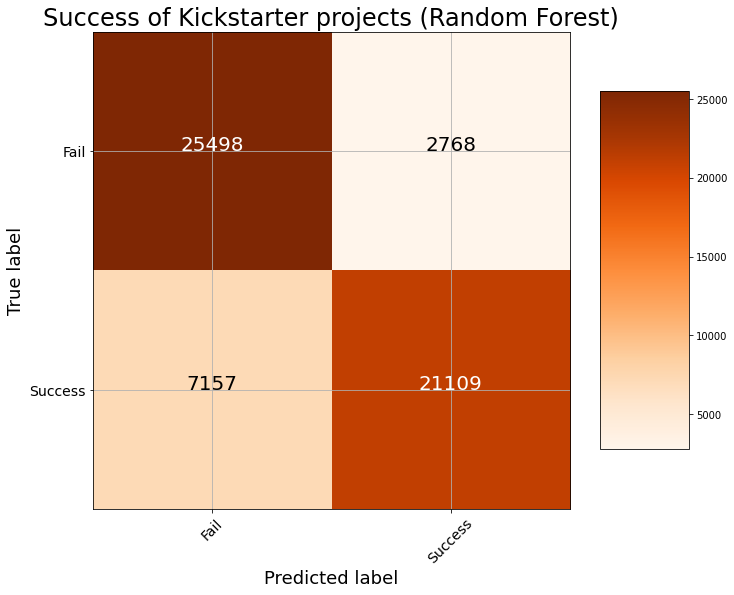

In [88]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None, 
    min_samples_split=2, 
    max_features='sqrt', 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1,
    random_state=RSEED
)
y_pred_rf = clf_train_predict(clf_rf, train, train_label, test)
cm = simple_metrics(test_label, y_pred_rf)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest)'
)

In [89]:
train.shape

(131906, 210)

In [91]:
len(features_dummies)
type(clf_rf.feature_importances_)
rf_fi = [(x, y) for x,y in zip(features_dummies,clf_rf.feature_importances_)]
rf_fi = sorted(rf_fi, key=lambda x : x[1], reverse=True)
for i in rf_fi[0:50]:
    print(f'{i[1]}:\t{i[0]}')

#print(rf_fi)

0.11547751019731749:	duration_start_launch
0.0917986427346405:	blurb_length
0.08481357493474069:	goal
0.07377928429566799:	duration
0.057892088563991244:	name_length
0.05353455936858908:	goal_per_duration
0.013957333146208117:	category_name_Digital Art
0.0124995037349212:	category_name_Video Art
0.011883346729798891:	category_name_Sculpture
0.011694388167887553:	month_12
0.010957539489543642:	category_name_Nature
0.010929213825954546:	category_name_Robots
0.01053926759346703:	category_name_Cookbooks
0.010420459703869773:	category_name_Ceramics
0.009981826096626477:	category_name_Festivals
0.00996005789833717:	category_name_Immersive
0.009712006542706857:	category_name_Musical
0.00964419465044455:	category_name_Comedy
0.0093738144924814:	category_name_Horror
0.009265845182844755:	category_name_Stationery
0.009179359638645633:	category_name_Printing
0.008825680889776822:	category_name_Weaving
0.0075394789328588705:	month_10
0.007474165457087392:	month_4
0.007439499059881021:	month_6
0.00

2. XGBoost

/Users/fklein/neuefische/day28_20211103_2nd_project/Kickstarter_project/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:49] WARNING: /private/var/folders/z6/20813vb106nfz9y_jy2g9srm0000gn/T/pip-install-mi2n0a_o/xgboost_38d03cb6f6d64205821378f63f122808/build/temp.macosx-11.2-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy_score 0.7897120215099412
f1-score 0.7788443650705064
Confusion matrix, without normalization
[[23711  4555]
 [ 7333 20933]]


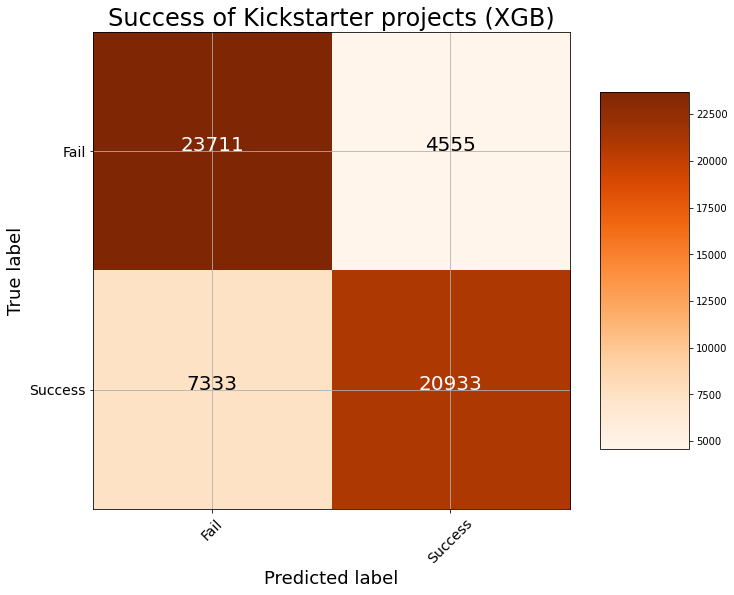

In [38]:
from xgboost import XGBClassifier 
clf_xgb = XGBClassifier( 
    n_estimators=100,
    #max_depth=20, 
    n_jobs=-1
)
y_pred_xgb = clf_train_predict(clf_xgb, train, train_label, test)
cm = simple_metrics(test_label, y_pred_xgb)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (XGB)'
)

3. Naive Bayes

accuracy_score 0.5156548503502442
f1-score 0.6726757600028691
Confusion matrix, without normalization
[[ 1016 27250]
 [  131 28135]]


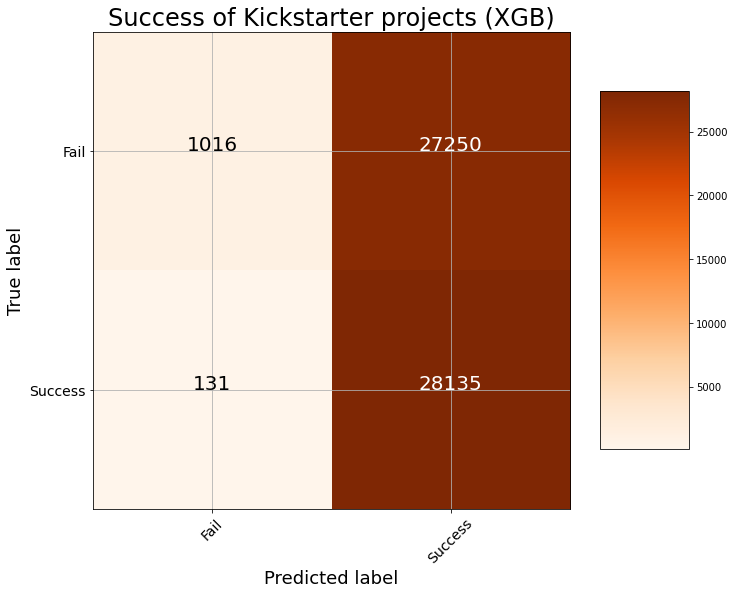

In [39]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
y_pred_gnb = clf_train_predict(clf_gnb, train, train_label, test)
cm = simple_metrics(test_label, y_pred_gnb)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (XGB)'
)

4. SVM / SGDClassifier

In [40]:
#SVC implementation, linear and rbf take too long (rbf took 9 min, still not finished)
#clf_svm = SVC(kernel='rbf', C=1)
#y_pred_svm = clf_train_predict(clf_svm, train, train_label, test)
#cm = simple_metrics(test_label, y_pred_svm)
#plot_confusion_matrix(
#    cm, classes=['Fail', 'Success'], 
#    title='Success of Kickstarter projects (SVM)'
#)


accuracy_score 0.5897367862449586
f1-score 0.6660811725240078
Confusion matrix, without normalization
[[10207 18059]
 [ 5134 23132]]


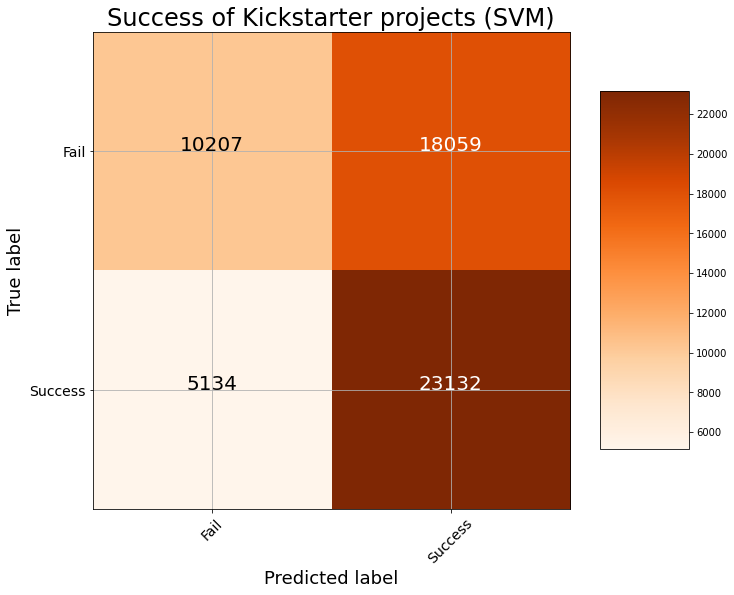

In [41]:
#SGDClassifier (hinge = linear SVC)
from sklearn.linear_model import SGDClassifier
clf_sgd = SGDClassifier(loss='hinge')
y_pred_sgd = clf_train_predict(clf_sgd, train, train_label, test)
cm = simple_metrics(test_label, y_pred_sgd)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (SVM)'
)

## Gridsearch using Random Forests

accuracy_score 0.8227906318545248
f1-score 0.8074794373126298
Confusion matrix, without normalization
[[25505  2761]
 [ 7257 21009]]


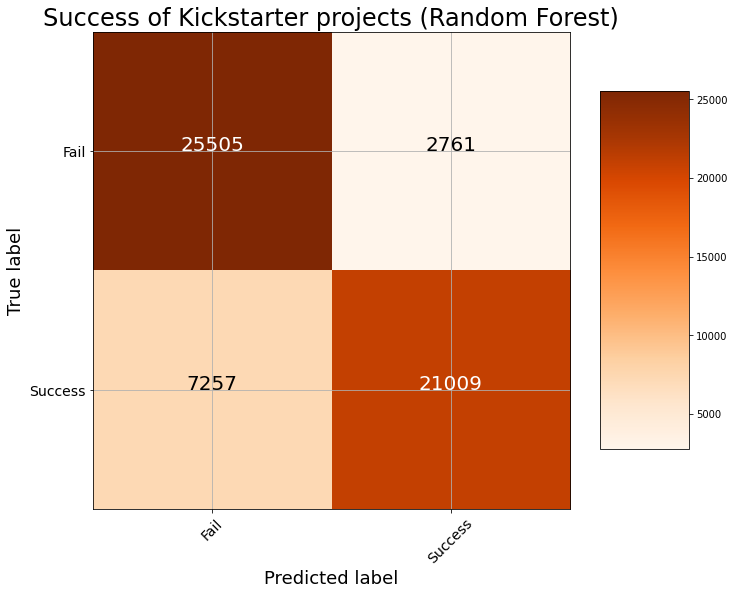

In [42]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None, 
    min_samples_split=2, 
    max_features='sqrt', 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1,
    random_state=RSEED
)
y_pred_rf = clf_train_predict(clf_rf, train, train_label, test)
cm = simple_metrics(test_label, y_pred_rf)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest)'
)

n_estimators=100
max_depth=None
min_samples_leaf=1
min_impurity_decrease=0.0


In [45]:
param_grid = {'n_estimators':[5, 20, 100], 'max_depth':[None, 10, 2], 
        'min_impurity_decrease':[0.0, 0.05], 'max_features':['sqrt', None]}

gs = RandomizedSearchCV(RandomForestClassifier(random_state=RSEED), param_grid, scoring='f1',
                  cv=5, verbose=1, n_jobs=-1, n_iter=5)

# Fit gridsearch object to data.. also lets see how long it takes

gs.fit(train, train_label)



Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 2],
                                        'max_features': ['sqrt', None],
                                        'min_impurity_decrease': [0.0, 0.05],
                                        'n_estimators': [5, 20, 100]},
                   scoring='f1', verbose=1)

In [46]:
best_score = gs.best_score_
best_params = gs.best_params_
print (best_score)
print (best_params)

0.7662801915951958
{'n_estimators': 100, 'min_impurity_decrease': 0.0, 'max_features': 'sqrt', 'max_depth': None}


accuracy_score 0.8227906318545248
f1-score 0.8074794373126298
Confusion matrix, without normalization
[[25505  2761]
 [ 7257 21009]]


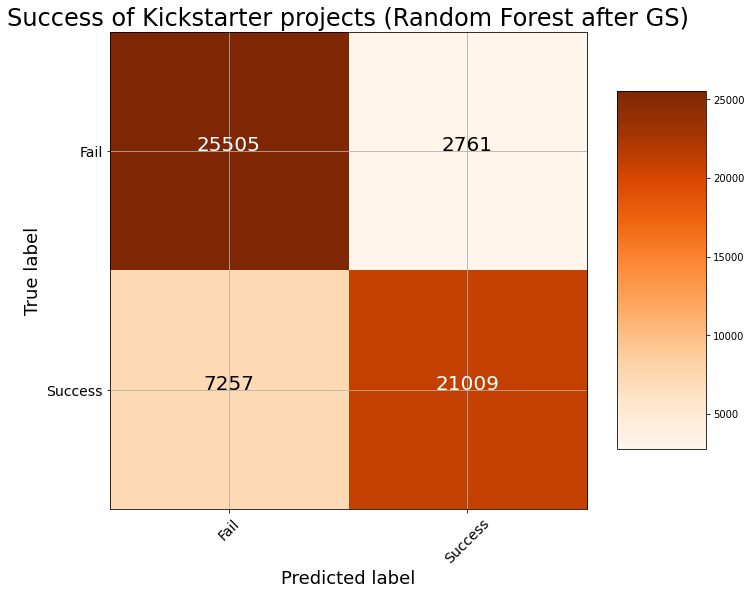

In [47]:
clf_rf_best = gs.best_estimator_

y_pred_rf_best = clf_train_predict(clf_rf_best, train, train_label, test)
cm = simple_metrics(test_label, y_pred_rf_best)
plot_confusion_matrix(
    cm, classes=['Fail', 'Success'], 
    title='Success of Kickstarter projects (Random Forest after GS)'
)


# Data cleaningin and feature engineering

In [50]:
coffee_features.info()

NameError: name 'coffee_features' is not defined

In [ ]:
#for this exercise we will only deal with numeric variables

X = coffee_features.select_dtypes(['number'])

## Splitting data for testing 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_train["altitude_mean_log"] = np.log(X_train["altitude_mean_meters"])
X_train.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_train.drop(['Quakers'], axis=1, inplace=True)
X_train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 17 to 6
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number.of.Bags        22 non-null     int64  
 1   Harvest.Year          22 non-null     int64  
 2   Fragrance...Aroma     22 non-null     float64
 3   Flavor                22 non-null     float64
 4   Aftertaste            22 non-null     float64
 5   Salt...Acid           22 non-null     float64
 6   Bitter...Sweet        22 non-null     float64
 7   Mouthfeel             22 non-null     float64
 8   Uniform.Cup           22 non-null     float64
 9   Clean.Cup             22 non-null     float64
 10  Balance               22 non-null     float64
 11  Cupper.Points         22 non-null     float64
 12  Total.Cup.Points      22 non-null     float64
 13  Moisture              22 non-null     float64
 14  Category.One.Defects  22 non-null     int64  
 15  Category.Two.Defects  22 

In [ ]:
altitude_low_meters_mean = X_train["altitude_low_meters"].mean()
altitude_high_meters_mean = X_train["altitude_high_meters"].mean()
altitude_mean_log_mean = X_train["altitude_mean_log"].mean()

In [ ]:
# fillna with mean.. 
X_train["altitude_low_meters"] = X_train["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_train["altitude_high_meters"] = X_train["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_train["altitude_mean_log"] = X_train["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [ ]:
print(f"altitude low meters mean is {altitude_low_meters_mean}")
print(f"altitude_high_meters_mean is {altitude_high_meters_mean}")
print(f"altitude_mean_log_mean is {altitude_mean_log_mean}")

altitude low meters mean is 1500.3684210526317
altitude_high_meters_mean is 1505.6315789473683
altitude_mean_log_mean is 7.0571530664031155


## Trainining the model

In [ ]:
## in order to exemplify how the predict will work.. we will save the y_train
X_test.to_csv("data/X_test.csv")
y_test.to_csv("data/y_test.csv")

In [ ]:
#training the model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
y_train_pred = reg.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print(mse)

6.701014816713759e-28


In [ ]:
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_test["altitude_mean_log"] = np.log(X_test["altitude_mean_meters"])
X_test.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_test.drop(['Quakers'], axis=1, inplace=True)
X_test.drop(['Unnamed: 0'], axis=1, inplace=True)
# fillna with mean.. 
X_test["altitude_low_meters"] = X_test["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_test["altitude_high_meters"] = X_test["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_test["altitude_mean_log"] = X_test["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [ ]:
y_test_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print(mse)

2.08680004794465e-27
